# Visualize and Evaluate model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib
import argparse
import os
from os.path import isfile,join
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import sys
sys.path.insert(1, '../utils')
sys.path.insert(1, '../datasets')
sys.path.insert(1, '../search')
import coco_utils as cu
import my_datasets as mdset
import eval_train as ev
import utils as U
import find_best_model as fbm
from matplotlib import colors


Bad key "text.kerning_factor" on line 4 in
/usr/lib64/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution





## Parameters

In [3]:
# DATASETS
dataroot_voc = '/share/DEEPLEARNING/datasets/voc2012'
dataroot_sbd = '/share/DEEPLEARNING/datasets/sbd'
dataroot_coco = '/share/DEEPLEARNING/datasets/coco'
dataroot_landcover = '/share/DEEPLEARNING/datasets/landcover'
dataroot_coco2voc = '/users/k/karmimy/data/coco2voc'
VOC = False

nw = 4 
pm = True
#MODEL SAVE AND LOAD 
load_dir = '/share/homes/karmimy/equiv/save_model' # Saved model dir
#exp = 'rot_equiv_lc' # Exp dir
exp = 'rot_equiv_lc' 
#model_name = 'rot_equiv_lc.pt' # saved model name
model_name = 'rot_equiv_lc.pt'
folder_model = join(load_dir,exp,'17') 
#fcn= True
#pretrained=True

# GPU 
gpu = 0
# EVAL PARAMETERS
bs = 4  

# LOSS 
criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.
Loss = 'KL' # Loss = 'KL' or 'CE' or None for L1,MSE…
criterion_unsupervised = U.get_criterion(Loss)


# SEARCH FOR A PARTICULAR MODEL 
rotate = False # random rotation during training
scale = False
split = False # split the supervised dataset
split_ratio = 0.3
batch_size = 4
pi_rotate = False

#scale_factor = (0.2,0.8)
#size_img = (420,420) 
#size_crop = (380,380)

# DEVICE
# Decide which device we want to run on
device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
print("device :",device)

device : cuda:0


In [4]:
model = torch.load(join(folder_model,model_name),map_location=device)


## DATASETS

In [5]:
if VOC :
        num_classes = 21
        train_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='train', \
                download=True,rotate=rotate,scale=scale,size_img=size_img,size_crop=size_crop)
        test_dataset = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=True)
        train_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='train_noval',mode='segmentation',\
                rotate=rotate,scale=scale,size_img=size_img,size_crop=size_crop)
        train_dataset = tud.ConcatDataset([train_dataset_VOC,train_dataset_SBD])
        
else:
        num_classes = 4
        print('Loading Landscape Dataset')
        train_dataset = mdset.LandscapeDataset(dataroot_landcover,image_set="trainval",\
            rotate=rotate)#,size_img=size_img,size_crop=size_crop)
        test_dataset = mdset.LandscapeDataset(dataroot_landcover,image_set="test")
        test_dataset_no_norm =  mdset.LandscapeDataset(dataroot_landcover,image_set="test",normalize=False)
        print('Success load Landscape Dataset')
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=bs,num_workers=nw,\
        pin_memory=pm,shuffle=True,drop_last=True)#,collate_fn=U.my_collate)
dataloader_val = torch.utils.data.DataLoader(test_dataset,num_workers=nw,pin_memory=pm,\
        batch_size=bs)

Loading Landscape Dataset
Success load Landscape Dataset


## Plot Losses and Metrics 

In [6]:
def plot_loss_metrics(folder,model_name):
    l_npy = [f for f in os.listdir(folder) if isfile(join(folder,f)) and f.endswith(".npy")] # Load all numpy file in the best folder
    for f in l_npy:
        curv = np.load(join(folder,f))
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.title(model_name.upper())
        plt.plot(curv)
        plt.xlabel("iterations")
        plt.ylabel(f.upper())



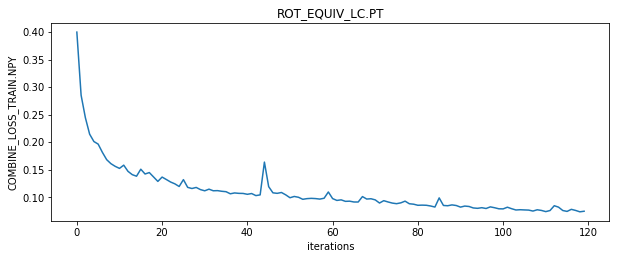

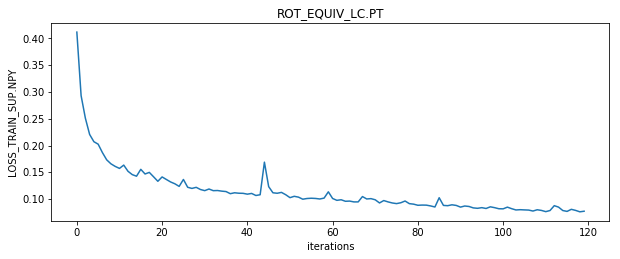

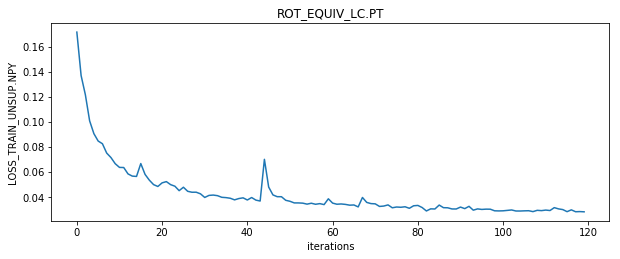

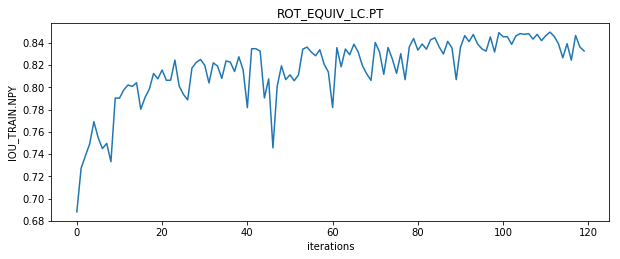

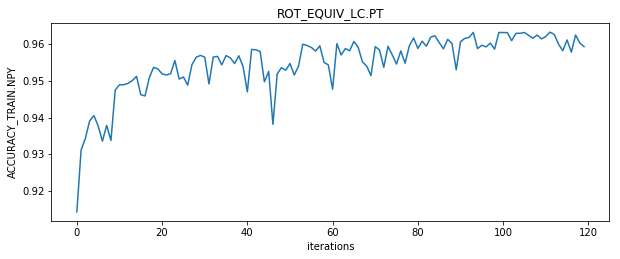

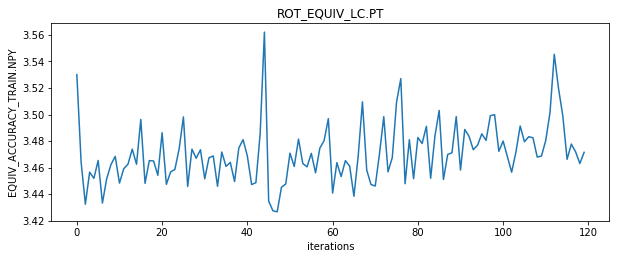

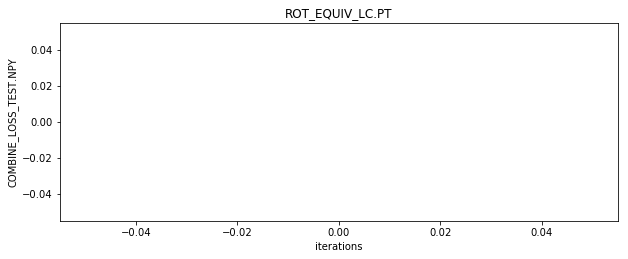

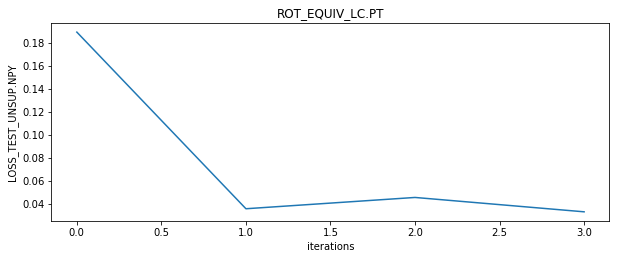

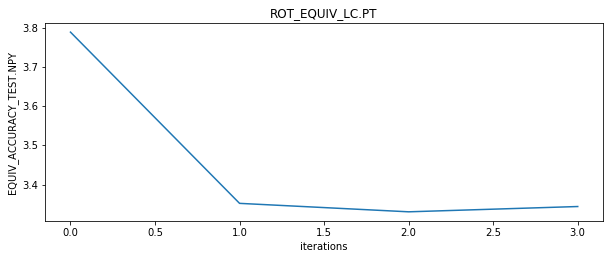

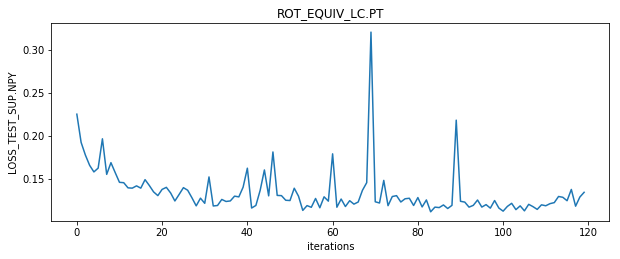

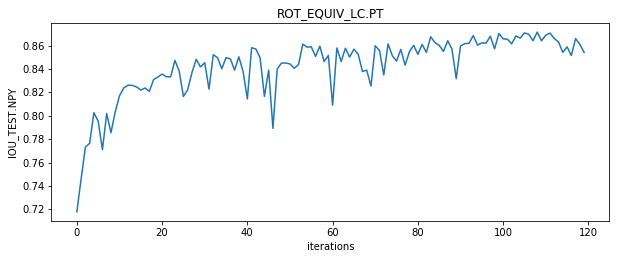

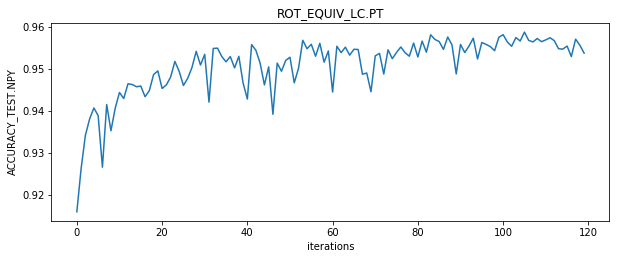

In [7]:
plot_loss_metrics(folder_model,model_name)

## SHOW MODEL PREDICTIONS

In [8]:
# PARAMETERS FOR THE VISUALIZATION 
NUMBER_EXAMPLES = 10
list_iter = np.random.randint(0,len(test_dataset),NUMBER_EXAMPLES) # TAKE N RANDOM IMAGES 
list_iter = np.arange(NUMBER_EXAMPLES)

angle_fix = 30
test_dataset = mdset.LandscapeDataset(dataroot_landcover,image_set="test",fixing_rotate=True,angle_fix=angle_fix)
dataloader_val = torch.utils.data.DataLoader(test_dataset,num_workers=nw,pin_memory=pm,\
    batch_size=bs)
CLASS = U.LANDCOVER_CLASS

CMAP_pred = U.get_cmap_landcover()
if angle_fix %90 !=  0:
    CMAP = U.get_cmap_landcover_rotate()

else:
    CMAP = U.get_cmap_landcover()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ITERATION 0 / 10
(tensor([0, 2]), tensor([ 57459, 204685]))
(tensor([-1,  2]), tensor([ 40556, 221588]))
Metrics on this example... IoU: 0.461854883838475 Accuracy tensor(0.7808)
ITERATION 1 / 10
../utils/utils.py:147: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(area_inter/area_union)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(tensor([0, 2]), tensor([ 64721, 197423]))
(tensor([-1,  0,  2]), tensor([ 40556,  15063, 206525]))
Metrics on this example... IoU: 0.42781557685633276 Accuracy tensor(0.7029)
ITERATION 2 / 10
(tensor([0, 2]), tensor([ 59400, 202744]))
(tensor([-1,  0,  2]), tensor([ 40556,   7391, 214197]))
Clipping input data to the valid range for imshow with RGB

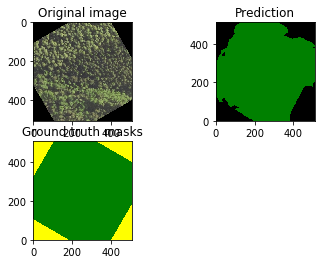

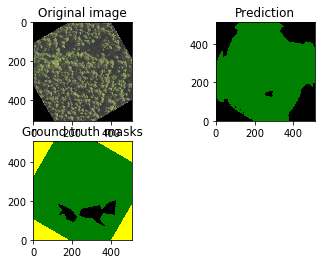

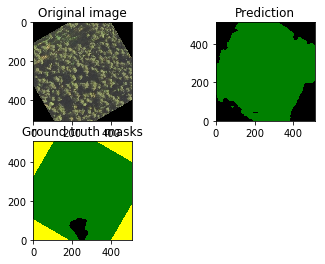

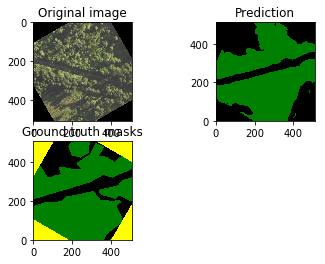

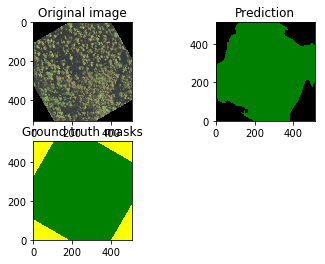

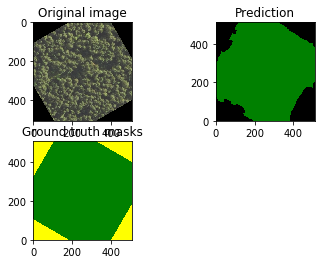

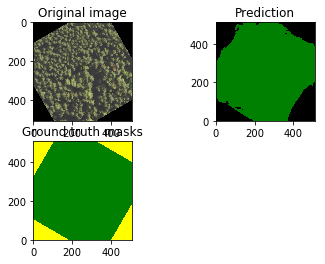

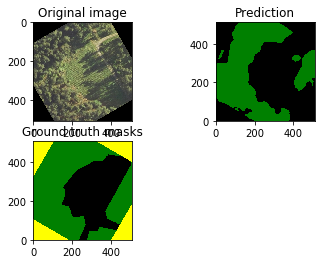

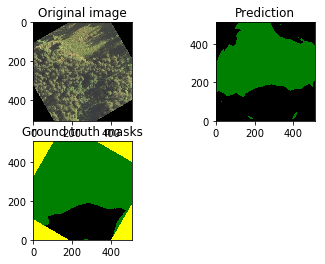

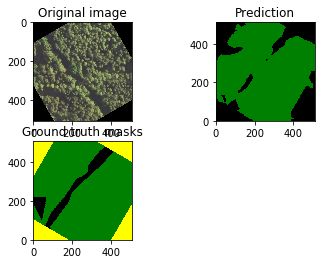

In [9]:
l_iou=[]
l_acc=[]
for i,im in enumerate(list_iter):
    print('ITERATION',i,'/',NUMBER_EXAMPLES)
    x,gt = test_dataset.__getitem__(im)
    im,_ = test_dataset_no_norm.__getitem__(im)
    x = x.unsqueeze(0).to(device)
    pred = model(x)
    pred = pred['out']

    #plot
    bounds=[-1,0,1,2,3]
    norm = colors.BoundaryNorm(bounds, CMAP.N)

    # tell imshow about color map so that only set colors are used

    im = TF.rotate(im,angle=angle_fix,expand=True,fill=-1)
    im = torch.transpose(im,0,2)
    im = torch.transpose(im,0,1)
    pred = pred.argmax(dim=1).squeeze().cpu()

    print(pred.unique(return_counts=True))
    print(gt.unique(return_counts=True))
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.title.set_text('Original image')

    ax1.imshow(im.cpu())
    ax2 = fig.add_subplot(2,2,2)
    ax2.title.set_text('Prediction')
    ax2.imshow(pred,cmap=CMAP,origin='lower',interpolation='nearest',norm=norm)
    ax3 = fig.add_subplot(2,2,3)
    ax3.title.set_text('Ground truth masks')
    ax3.imshow(gt.cpu(),cmap=CMAP,origin='lower',interpolation='nearest',norm=norm)
    
    # Metrics 
    iou = U.inter_over_union(pred,gt)
    acc = torch.sum(pred==gt).float()/(pred.size()[0]*pred.size()[1])
    l_iou.append(iou)
    l_acc.append(acc)
    print("Metrics on this example... IoU:",iou,"Accuracy",acc)
print("Mean IoU",np.array(l_iou).mean(),"Mean Accuracy",np.array(l_acc).mean())

In [15]:
gt.unique(return_counts=True)

(tensor([0, 1, 3]), tensor([  2228,  24171, 235745]))

In [16]:
pred.unique(return_counts=True)

(tensor([1, 3]), tensor([ 17528, 244616]))

## EVAL IoU ALL ANGLES

In [19]:
state = ev.eval_model(model,dataloader_val,device=device,num_classes=4)
iou = state.metrics['mean IoU']
acc = state.metrics['accuracy']
loss = state.metrics['CE Loss']

In [20]:
iou

0.8848092012951476

In [10]:
model_dir

'/share/homes/karmimy/equiv/save_model/rot_equiv_lc/8'

In [24]:
l_angles = [320,330,340,350,0,10,20,30,40]
l_iou = []
for angle in l_angles:
    test_dataset = mdset.LandscapeDataset(dataroot_landcover,image_set="test",fixing_rotate=True,angle_fix=angle)
    dataloader_val = torch.utils.data.DataLoader(test_dataset,num_workers=nw,pin_memory=pm,\
        batch_size=bs)
    state = ev.eval_model(model,dataloader_val,device=device,num_classes=4)
    iou = state.metrics['mean IoU']
    acc = state.metrics['accuracy']
    loss = state.metrics['CE Loss']
    print('EVAL FOR ANGLE',angle,': IOU',iou,', ACCURACY',acc,', LOSS',loss)
    l_iou.append(state.metrics['mean IoU'])

EVAL FOR ANGLE 320 : IOU 0.8043453247330059 , ACCURACY 0.9384183776512575 , LOSS 0.18411569202437383
EVAL FOR ANGLE 330 : IOU 0.819501584400211 , ACCURACY 0.9424579610836491 , LOSS 0.16264329926946786
EVAL FOR ANGLE 340 : IOU 0.8275142225470956 , ACCURACY 0.9473130610700553 , LOSS 0.14700540264001052
EVAL FOR ANGLE 350 : IOU 0.8449478968568459 , ACCURACY 0.950885277413548 , LOSS 0.13739842332704236
EVAL FOR ANGLE 0 : IOU 0.8848092012951476 , ACCURACY 0.961854791819826 , LOSS 0.10219012009219433
EVAL FOR ANGLE 10 : IOU 0.8427540364065971 , ACCURACY 0.9503829875093572 , LOSS 0.138091879093394
EVAL FOR ANGLE 20 : IOU 0.8256100078052548 , ACCURACY 0.9462096205960201 , LOSS 0.15074267250470602
EVAL FOR ANGLE 30 : IOU 0.8176716217210489 , ACCURACY 0.942649400784877 , LOSS 0.1617227237620455
EVAL FOR ANGLE 40 : IOU 0.8038350429035761 , ACCURACY 0.9400456746419271 , LOSS 0.16897634441932935


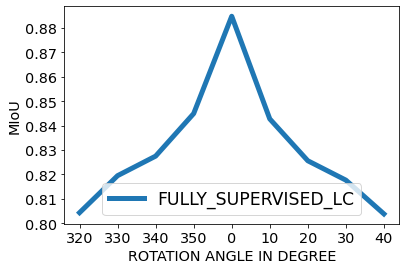

In [25]:
l_angles = [str(i) for i in l_angles] 
plt.figure()
#plt.title('Evolution of the IoU VAL VOC 2012 according to the rotation of the input images.')
plt.plot(l_angles,l_iou,label=exp.upper(),linewidth=5.0)
#plt.plot(angle,fcn_multi_task_val,label='FCN multi-tasks '+r'$\mathcal{LE}_{CE}$',linewidth=5.0)
#plt.plot(angle,fcn_semisup_val,label='FCN semi-sup '+r'$\mathcal{LE}_{CE}$',linewidth=5.0)
#plt.plot(angle,fcn_semisup_val_KL,label='(Ours) FCN semi-sup '+r'$\mathcal{LE}_{KL}$',linewidth=5.0)
#plt.plot(angle,fcn_rot_sup_val,"--",label='FCN Rot*',linewidth=5.0)
##plt.plot(angle,fcn_sup_rot_val,label='fcn_sup rotation data aug')
plt.xlabel("ROTATION ANGLE IN DEGREE",fontsize='x-large')
plt.ylabel("MIoU",fontsize='x-large')
plt.legend(loc="lower center",fontsize='xx-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.show()